# 1.2 Preprocessing Basics


## 0) Setup & Paths

In [26]:
from pathlib import Path
from collections import Counter
import numpy as np
from PIL import Image, ImageOps, ImageDraw
import matplotlib.pyplot as plt



## 1) Read in and print the cow image from the [Coco 2017 Dataset](https://www.kaggle.com/datasets/awsaf49/coco-2017-dataset)

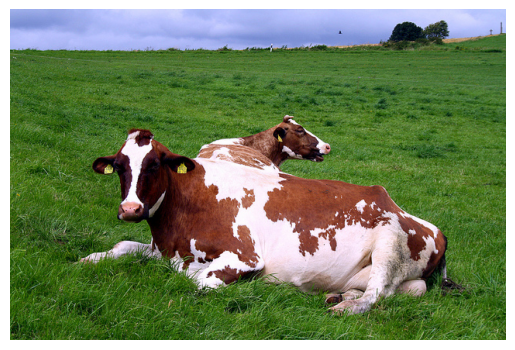

In [27]:

# Replace with your filename
FNAME = "COCO_Sample/000000000019.jpg"

# Open the image
img = Image.open(FNAME)

# Show it
plt.imshow(img)
plt.axis("off")
plt.show()


## 2) Perform EXIF rotation if necessary

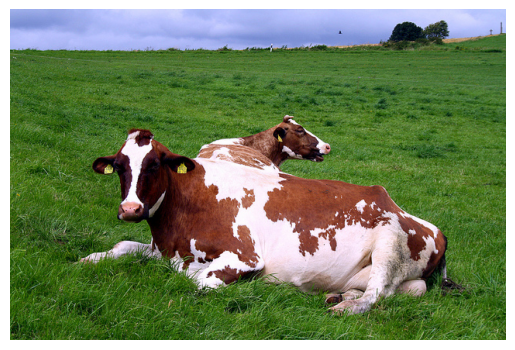

In [28]:
#Do EXIF rotation

img = ImageOps.exif_transpose(img)

# Show it
plt.imshow(img)
plt.axis("off")
plt.show()

## 3) Look at the reaw data

In [29]:
arr = np.array(img)   # (H, W, C)

print('Type:', type(arr))
print('Dtype:', arr.dtype)         # typically uint8 (0..255)
print('Shape (H, W, C):', arr.shape)
print('Top-left pixel RGB:', arr[0,0,:])
print('Raw Data', arr[1:4,1:4,:])



Type: <class 'numpy.ndarray'>
Dtype: uint8
Shape (H, W, C): (427, 640, 3)
Top-left pixel RGB: [160 179 238]
Raw Data [[[160 176 236]
  [161 175 236]
  [163 174 236]]

 [[155 175 234]
  [158 174 234]
  [159 173 234]]

 [[152 174 232]
  [154 173 232]
  [156 172 232]]]


## 4) Visualize individual channel data 

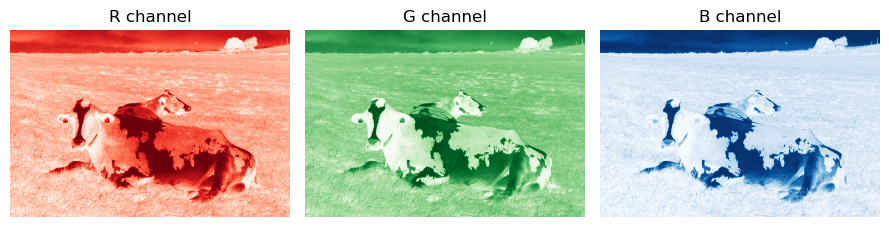

In [30]:

r, g, b = arr[:,:,0], arr[:,:,1], arr[:,:,2]
plt.figure(figsize=(9,3))
plt.subplot(1,3,1); plt.imshow(r, cmap='Reds'); plt.title('R channel'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(g, cmap='Greens'); plt.title('G channel'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(b, cmap='Blues'); plt.title('B channel'); plt.axis('off')
plt.tight_layout(); plt.show()

## 5) Geometry: letterbox (pad), center-crop+resize, stretch



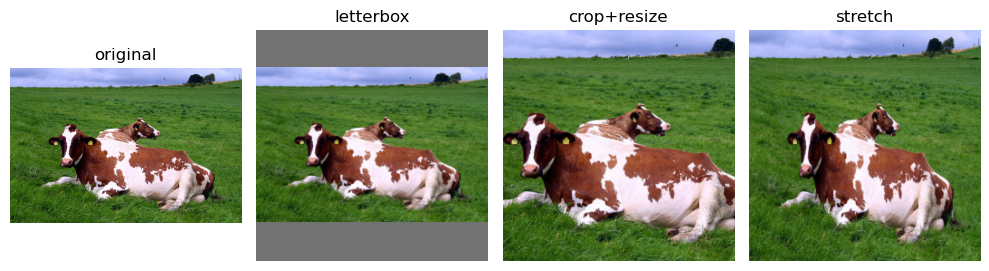

In [31]:


def letterbox_pil(pil_img, target_w=256, target_h=256, pad_color=(114, 114, 114)):
    """Resize to fit inside (target_w, target_h) without distortion, then pad (letterbox)."""
    w, h = pil_img.size                              # original width/height (Pillow gives (W, H))

    scale = min(target_w / w, target_h / h)          # scale so neither side exceeds target
    new_w, new_h = int(round(w * scale)), int(round(h * scale))  # integer resized dims

    resized = pil_img.resize((new_w, new_h),         # resize with preserved aspect ratio
                             resample=Image.BILINEAR)  # bilinear = good default for photos

    canvas = Image.new('RGB', (target_w, target_h),  # make target-sized background
                       color=pad_color)              # fill with neutral gray bars

    dx = (target_w - new_w) // 2                     # left offset to center horizontally
    dy = (target_h - new_h) // 2                     # top offset to center vertically

    canvas.paste(resized, (dx, dy))                  # paste the resized image onto the canvas

    return canvas                                    # final letterboxed image (exact target size)


def center_crop_then_resize(pil_img, target_w=256, target_h=256):
    """Crop the center to match target aspect ratio, then resize exactly to (target_w, target_h)."""
    w, h = pil_img.size                              # original width/height (Pillow returns (W, H))

    target_aspect = target_w / target_h              # aspect ratio we want (e.g., 256/256 = 1:1)
    current_aspect = w / h                           # aspect ratio the image currently has

    if current_aspect > target_aspect:               # image is "too wide" relative to target
        new_w = int(round(h * target_aspect))        # compute width that matches target aspect
        left = (w - new_w) // 2                      # center the crop horizontally
        box = (left, 0, left + new_w, h)             # (left, top, right, bottom) crop rectangle
    else:                                            # image is "too tall" (or equal aspect)
        new_h = int(round(w / target_aspect))        # compute height that matches target aspect
        top = (h - new_h) // 2                       # center the crop vertically
        box = (0, top, w, top + new_h)               # centered vertical crop

    cropped = pil_img.crop(box)                      # perform the center crop to target aspect

    return cropped.resize((target_w, target_h),      # resize cropped image to the exact target size
                          resample=Image.BILINEAR)   # bilinear = good default for photos
    # NOTE: for masks/label images, use Image.NEAREST instead of bilinear to avoid mixing class IDs.


def stretch_resize(pil_img, target_w=256, target_h=256):
    """Resize directly to (target_w, target_h), ignoring aspect ratio (shapes may distort)."""
    return pil_img.resize((target_w, target_h),      # force both width and height to target
                          resample=Image.BILINEAR)   # fast and simple; may squash/stretch content

lb  = letterbox_pil(img, TARGET_W, TARGET_H)
cr  = center_crop_then_resize(img, TARGET_W, TARGET_H)
strz = stretch_resize(img, TARGET_W, TARGET_H)

plt.figure(figsize=(10,3))
plt.subplot(1,4,1); plt.imshow(img);  plt.title('original');     plt.axis('off')
plt.subplot(1,4,2); plt.imshow(lb);   plt.title('letterbox');    plt.axis('off')
plt.subplot(1,4,3); plt.imshow(cr);   plt.title('crop+resize');  plt.axis('off')
plt.subplot(1,4,4); plt.imshow(strz); plt.title('stretch');      plt.axis('off')
plt.tight_layout(); plt.show()

## 6) Intensity: rescale, standardize (dataset μ/σ), per-image normalize

- **Rescale** puts values in **[0,1]** (unit change only).  
- **Standardize** uses dataset **mean/std per channel**.  
- **Per-image normalize** uses **that image's** mean/std.

*For class demo we use all images to compute means/stds. In real projects, compute on **train only** and reuse on val/test.*


In [32]:
#Lets use crop and resize  Change to lb for letterbox or strz for stretch

x01  = np.array(cr).astype(np.float32) / 255.0

print('Scaled Data', x01[1:4,1:4,:])

Scaled Data [[[0.70980394 0.75686276 0.99215686]
  [0.70980394 0.7607843  0.99607843]
  [0.7176471  0.7607843  1.        ]]

 [[0.7019608  0.7490196  0.9882353 ]
  [0.69803923 0.75686276 0.99215686]
  [0.7058824  0.7607843  0.99607843]]

 [[0.6862745  0.7372549  0.9764706 ]
  [0.69411767 0.74509805 0.9843137 ]
  [0.70980394 0.7490196  0.99215686]]]


In [33]:
## 7) Load all images 

In [34]:
IMG_DIR = Path("./COCO_Sample")

# list files in folder
files = sorted([p for p in IMG_DIR.iterdir() if p.is_file()])

print(f"Found {len(files)} image(s) in {IMG_DIR.resolve()}")
for p in files:
    print(p.name) 


Found 10 image(s) in C:\Users\chelseam\OneDrive - Full Sail University\Desktop\Computer Vision\Computer_Vision\COCO_Sample
000000000019.jpg
000000000025.jpg
000000000030.jpg
000000000034.jpg
000000000036.jpg
000000000194.jpg
000000000471.jpg
000000000502.jpg
000000000801.jpg
000000000839.jpg


## 8) Standardize based on one mean and one std per color channel across all pixels of all images in the training set.

In [35]:


# ---- streaming stats (sum and sum of squares) ----
sum_rgb  = np.zeros(3, dtype=np.float64)
sum2_rgb = np.zeros(3, dtype=np.float64)
pixel_count = 0

skipped = []

for p in files:
    with Image.open(p) as im:
        im = ImageOps.exif_transpose(im)

# 3) Accumulate stats (use float to avoid overflow)
        flat = arr.reshape(-1, 3).astype(np.float64)      # (N, 3), values 0..255
        sum_rgb  += flat.sum(axis=0)
        sum2_rgb += (flat ** 2).sum(axis=0)
        pixel_count += flat.shape[0]


mean = sum_rgb / pixel_count
var  = sum2_rgb / pixel_count - mean**2
std  = np.sqrt(np.maximum(var, 0.0))

print("\nPer-channel stats (0..255 scale):")
print("  mean R,G,B =", mean.astype(np.float32))
print("  std  R,G,B =", std.astype(np.float32))

# (Optional) also report in [0,1] if you plan to rescale inputs later
print("\nPer-channel stats (scaled to [0,1]):")
print("  mean R,G,B =", (mean / 255.0).astype(np.float32))
print("  std  R,G,B =", (std / 255.0).astype(np.float32))




Per-channel stats (0..255 scale):
  mean R,G,B = [100.17008 118.39234  78.72868]
  std  R,G,B = [61.20352  51.401398 82.46166 ]

Per-channel stats (scaled to [0,1]):
  mean R,G,B = [0.39282385 0.4642837  0.30873993]
  std  R,G,B = [0.24001382 0.2015741  0.32337907]


## 9) Calculate standardized values for cow image

In [36]:
mean01 = np.array([0.39282385, 0.4642837, 0.30873993], dtype=np.float32)
std01  = np.array([0.24001382, 0.2015741, 0.32337907], dtype=np.float32)

x_std = (x01 - mean01.reshape(1, 1, 3)) / (std01.reshape(1, 1, 3) + 1e-8)

print('Scaled and Standardized Data', x_std[1:4,1:4,:])

Scaled and Standardized Data [[[1.3206743 1.4514713 2.1133618]
  [1.3206743 1.470926  2.1254885]
  [1.3533521 1.470926  2.1376154]]

 [[1.2879964 1.4125619 2.1012347]
  [1.2716575 1.4514713 2.1133618]
  [1.3043354 1.470926  2.1254885]]

 [[1.2226406 1.3541977 2.0648544]
  [1.2553185 1.3931072 2.089108 ]
  [1.3206743 1.4125619 2.1133618]]]
